In [1]:
from datasets import load_dataset

In [2]:
import ast

In [3]:
data = load_dataset("humarin/chatgpt-paraphrases")

In [4]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'paraphrases', 'category', 'source'],
        num_rows: 419197
    })
})

In [5]:
min_num_words = 50

In [6]:
filtered_data = data.filter(lambda x: x["category"] == "sentence")

In [7]:
filtered_data = filtered_data.filter(lambda x: (len(x["text"].split()) > min_num_words))

In [8]:
def rollout(batch):
    ret_batch = {
        "input": [],
        "output": [],
    }
    for text, pars in zip(batch["text"], batch["paraphrases"]):
        for p in ast.literal_eval(pars):
            ret_batch["input"].append(text)
            ret_batch["output"].append(p)
    return ret_batch

In [9]:
filtered_data = filtered_data["train"].map(
    rollout,
    batched=True,
    batch_size=2,
    remove_columns=filtered_data["train"].column_names
)

In [10]:
filtered_data

Dataset({
    features: ['input', 'output'],
    num_rows: 15940
})

In [11]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

In [12]:
model = AutoModel.from_pretrained('nvidia/NV-Embed-v2', trust_remote_code=True)

/home/jovyan/.mlspace/envs/cheap_with_dif/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/jovyan/.mlspace/envs/cheap_with_dif/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
model = model.cuda()

In [19]:
batch_size = 10

In [20]:
input_ = filtered_data["input"][:batch_size]
output_ = filtered_data["output"][:batch_size]

In [33]:
torch.cuda.empty_cache()

In [22]:
with torch.no_grad():
    input_embeddings = model.encode(input_, normalize_embeddings=True)

In [23]:
with torch.no_grad():
    output_embeddings = model.encode(output_, normalize_embeddings=True)

In [25]:
scores = (input_embeddings @ output_embeddings.T) * 100
print(scores.tolist())

[[87.178466796875, 92.79225158691406, 87.91120147705078, 88.95439147949219, 91.80231475830078, 18.73691177368164, 16.15211296081543, 18.442310333251953, 16.879009246826172, 14.502303123474121], [87.178466796875, 92.79225158691406, 87.91120147705078, 88.95439147949219, 91.80231475830078, 18.73691177368164, 16.15211296081543, 18.442310333251953, 16.879009246826172, 14.502303123474121], [87.178466796875, 92.79225158691406, 87.91120147705078, 88.95439147949219, 91.80231475830078, 18.73691177368164, 16.15211296081543, 18.442310333251953, 16.879009246826172, 14.502303123474121], [87.178466796875, 92.79225158691406, 87.91120147705078, 88.95439147949219, 91.80231475830078, 18.73691177368164, 16.15211296081543, 18.442310333251953, 16.879009246826172, 14.502303123474121], [87.178466796875, 92.79225158691406, 87.91120147705078, 88.95439147949219, 91.80231475830078, 18.73691177368164, 16.15211296081543, 18.442310333251953, 16.879009246826172, 14.502303123474121], [15.528077125549316, 16.8631896972

In [40]:
en_wiki = load_dataset('ltg/en-wiki-paraphrased', split='train')

In [42]:
en_wiki = en_wiki.filter(lambda x: (len(x["original"].split()) > 50) and (len(x["original"].split()) < 100))

Filter:   0%|          | 0/6035374 [00:00<?, ? examples/s]

In [43]:
en_wiki

Dataset({
    features: ['original', 'paraphrase'],
    num_rows: 5288593
})

In [46]:
input_ = en_wiki[:20]["original"]
output_ = en_wiki[:20]["paraphrase"]

In [47]:
with torch.no_grad():
    input_embeddings = model.encode(input_, normalize_embeddings=True)

In [48]:
with torch.no_grad():
    output_embeddings = model.encode(output_, normalize_embeddings=True)

In [49]:
scores = (input_embeddings @ output_embeddings.T) * 100

In [50]:
for s in scores:
    out = [f"{c:0.3f}" for c in s]
    out = " ".join(out)
    print(out)

90.280 0.857 2.397 3.850 -4.180 3.887 2.470 4.400 9.384 7.595 6.867 4.545 0.354 4.689 1.419 1.243 7.343 0.383 9.847 4.398
1.035 83.624 -6.294 2.571 -1.595 9.801 2.717 -1.312 6.606 8.768 0.643 8.932 -5.500 7.106 -4.671 -6.222 0.121 8.138 0.852 8.104
-0.613 -7.881 84.128 10.408 -6.554 -2.436 -3.971 3.911 6.563 3.741 -1.911 8.646 17.342 -1.606 3.459 1.658 1.061 5.886 -4.548 4.135
6.254 4.772 11.435 85.174 1.105 2.560 -0.379 -1.730 8.056 9.550 11.943 19.697 6.388 4.325 4.914 4.263 2.184 2.738 -0.740 4.966
-3.397 0.983 -4.750 9.575 68.811 10.255 5.047 2.389 -2.891 -1.841 2.999 -4.997 -1.414 -1.243 -0.808 5.069 4.610 2.874 2.371 -1.212
3.869 6.618 -2.193 1.822 11.593 82.008 -3.084 -4.607 3.444 3.256 1.618 -2.701 2.281 2.700 -4.985 -0.194 0.576 0.361 2.728 4.714
2.618 4.971 -4.084 2.043 5.295 -4.402 89.916 4.131 -2.771 4.659 1.378 -1.378 -2.440 1.086 -0.657 -1.891 1.883 -1.393 6.112 5.429
7.653 5.384 4.790 -0.680 0.065 -3.021 6.096 74.477 4.434 0.449 -2.353 7.058 -0.750 3.670 8.322 2.087 -0.3

In [51]:
input_[0]

"In 1928 he submitted a patent application for the linear accelerator, not knowing of Gustav Ising's prior 1924 journal article and Rolf Widerøe's operational device, and in 1929 applied for one for the cyclotron. He was also the first person to conceive the idea of the electron microscope, and submitted the earliest patent for one in 1928."

In [53]:
input_[1]

'On 9 March the 1st Infantry Regiment began moving towards Ta Luong and advance elements sighted PAVN tanks near the area. Further north 1st Regiment observation teams saw a PAVN armored group and directed artillery fire onto it, disabling five tanks. To the southeast the Marines had been receiving heavy attacks by fire, but while searching 10\xa0km south-southeast from their bases found a PAVN base that had been bombed by B-52s containing 5,000 heavy rockets and large quantities of destroyed weapons and ammunition.'

In [52]:
input_[-2]

"The pisco sour underwent several changes until Mario Bruiget, a Peruvian bartender working at Morris' Bar, created the modern Peruvian recipe for the cocktail in the latter part of the 1920s by adding Angostura bitters and egg whites to the mix.\nCocktail connoisseurs consider the pisco sour a South American classic."

In [54]:
input_embeddings[0] @ input_embeddings[0].T

/tmp/ipykernel_2522/4023622781.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647352509/work/aten/src/ATen/native/TensorShape.cpp:3683.)
  input_embeddings[0] @ input_embeddings[0].T


tensor(1.0000, device='cuda:0')

In [17]:
import torch

In [18]:
result = torch.load("../para_embeddings.pth")

/tmp/ipykernel_4373/1900111756.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  result = torch.load("../para_embeddings.pth")


In [19]:
3067784 / 1024 / 1024 / 1024

0.002857096493244171

In [20]:
score = torch.sum(result["input_embeddings"] * result["output_embeddings"], dim=1)

In [21]:
score

tensor([0.9030, 0.9110, 0.9212,  ..., 0.9372, 0.9097, 0.9197])

In [16]:
result

{'input_embeddings': tensor([[-0.0038,  0.0058, -0.0061,  ..., -0.0130,  0.0085,  0.0250],
         [ 0.0132, -0.0170,  0.0070,  ..., -0.0067,  0.0085, -0.0271],
         [ 0.0031, -0.0034,  0.0111,  ..., -0.0130,  0.0004, -0.0172],
         [ 0.0004, -0.0060,  0.0178,  ..., -0.0015, -0.0168,  0.0223],
         [-0.0133, -0.0298,  0.0053,  ...,  0.0039,  0.0116,  0.0124]]),
 'output_embeddings': tensor([[-3.1196e-03,  6.6308e-03, -6.3631e-03,  ..., -9.6527e-03,
           1.5991e-02,  2.5508e-02],
         [ 1.8840e-02, -1.7060e-02,  1.9832e-05,  ..., -5.8305e-03,
           7.8727e-03, -2.7115e-02],
         [ 7.8626e-04, -5.3701e-03,  1.0043e-02,  ..., -1.3857e-02,
           5.2782e-03, -1.5857e-02],
         [-1.0034e-03, -7.3842e-03,  1.6972e-02,  ..., -3.2110e-03,
          -7.5875e-03,  2.3420e-02],
         [-1.3430e-02, -2.8129e-02,  2.8303e-03,  ...,  9.0568e-03,
           6.5509e-03,  1.0210e-02]]),
 'input': ['On January 25, 2018, Kamelot announced their twelfth studio alb

In [22]:
scores = (result["input_embeddings"] @ result["output_embeddings"].T) * 100

In [23]:
scores, indices = torch.sort(scores, dim=1, descending=True)

In [24]:
scores

tensor([[ 90.2970,  35.8181,  29.3209,  ...,  -8.8128,  -8.8662,  -8.9934],
        [ 91.1036,  29.7955,  29.7097,  ...,  -8.3959,  -8.5164,  -8.9050],
        [ 92.1164,  30.8146,  28.8363,  ...,  -7.0514,  -7.0857,  -8.1452],
        ...,
        [ 93.7236,  34.7941,  32.4936,  ...,  -8.3081,  -8.3831,  -8.9847],
        [ 90.9673,  38.7315,  34.7444,  ...,  -9.4917,  -9.5098, -10.4479],
        [ 91.9662,  41.4882,  39.4409,  ...,  -8.9766,  -9.4246,  -9.6154]])

In [25]:
indices

tensor([[   0, 1209, 6545,  ..., 2783, 5953, 6044],
        [   1, 3809, 9825,  ...,  846, 8568, 2784],
        [   2, 2840, 1341,  ..., 1927, 9635, 6496],
        ...,
        [9997, 8372, 5793,  ..., 3075, 1653, 9454],
        [9998,  601, 6442,  ..., 9138,  933, 6119],
        [9999, 5343, 9933,  ..., 8706, 5800, 9533]])

In [36]:
anchor = result["input"]
positive = result["output"]
positive_score = scores[:, 0].tolist()
hard_negative_1 = [result["output"][ind[1].item()] for ind in indices]
hard_negative_score_1 = scores[:, 1].tolist()
hard_negative_2 = [result["output"][ind[2].item()] for ind in indices]
hard_negative_score_2 = scores[:, 2].tolist()

In [32]:
from datasets import Dataset

In [37]:
dt = Dataset.from_dict(
    {
        "anchor": anchor,
        "positive": positive,
        "positive_score": positive_score,
        "hard_negative_1": hard_negative_1,
        "hard_negative_score_1": hard_negative_score_1,
        "hard_negative_2": hard_negative_2,
        "hard_negative_score_2": hard_negative_score_2,
    }
)

In [38]:
dt[0]

{'anchor': "In 1928 he submitted a patent application for the linear accelerator, not knowing of Gustav Ising's prior 1924 journal article and Rolf Widerøe's operational device, and in 1929 applied for one for the cyclotron. He was also the first person to conceive the idea of the electron microscope, and submitted the earliest patent for one in 1928.",
 'positive': 'In the year 1928, he filed an application for the invention of the linear accelerator, oblivious to the fact that Gustav Ising had published an article describing such a mechanism four years earlier, and Rolf Widerøe had developed an operational version of it. The next year, he submitted another patent application for the creation of the cyclotron, making him the first individual to envision this technology. Additionally, he was the pioneer behind the concept of the electron microscope, submitting the initial patent request for it in the same year.',
 'positive_score': 90.2969741821289,
 'hard_negative_1': 'The notion of d

In [40]:
dt.save_to_disk("../en_wiki_paraphrase")

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

In [41]:
import matplotlib.pyplot as plt

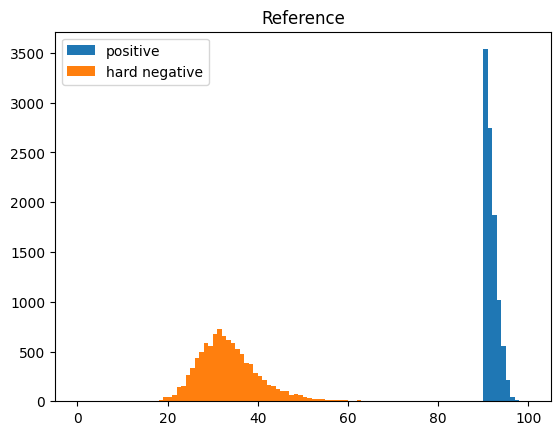

In [46]:
plt.hist(dt["positive_score"], range=(0, 100), label="positive", bins=100)
plt.hist(dt["hard_negative_score_1"], range=(0, 100), label="hard negative", bins=100)

plt.title("Reference")
plt.legend()
plt.show()